### z50, rgal, r50 y krot vs Mgal

In [1]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import time_conversion as time
import bines2 as bines
import make_profiles as mprof
import z50
import kapparot as k_rot

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

path = '/store/erebos/omarioni/_simulations/snap_127/'

# --- listas para guardar resultados ---
results = []

num=12
for j in range(num):

    snap = h5py.File(path + 'subhalo_'+str('%d'%ID[j])+'.h5py', 'r')

    print('subhalo_'+str('%d'%ID[j]))
    
    Id = ''
    for aux in list(str('%d'%ID[j]))[-2:]:
        Id += aux

    aexp = snap['/Time'][()]
    h    = snap['/h'][()]
    Om_L = snap['/Omega_Lambda'][()]
    Om_M = snap['/Omega_0'][()]
    Rvir = snap['/R200'][()]

    pstr = snap['/Str/Coordinates'][()]
    mstr = snap['/Str/Masses'][()]
    vstr = snap['/Str/Velocities'][()]

    sft  = snap['/Str/FormationTime'][()]
    met  = snap['/Str/Metallicity'][()]
    tmet = snap['/Str/Total_Metallicity'][()]

    amask, = np.where(sft>0) #aca puede haber particulas con age<0, esas no son estrellas son gas cells.
    ages = time.conv2(sft[amask], h, Om_L, Om_M) #transformo el tiempo de formacion de factor de escala a Gyr
    age  = np.max(ages) - ages #lo resto asi saco la edad de las particulas (inverso al tiempo de form)
    
    Ztot = tmet[amask]/0.0127

    xstr = pstr[amask,0]*aexp/h
    ystr = pstr[amask,1]*aexp/h
    zstr = pstr[amask,2]*aexp/h
    rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

    v_x = vstr[amask,0] *np.sqrt(aexp)
    v_y = vstr[amask,1] *np.sqrt(aexp)
    v_z = vstr[amask,2] *np.sqrt(aexp)

    #----------------------masas----------------------------
    mstr = mstr[amask]*1e10/h

    rgal = 0.15*Rvir*aexp/h

    limit, = np.where(rstr < rgal)
    rsort = np.argsort(rstr[limit])
    Mc = np.cumsum(mstr[limit][rsort])
    Mgal = Mc[-1]
    limit50, = np.where(Mc < Mgal/2)
    r50 = rstr[limit][rsort][limit50][-1]

    veloc,=np.where(rstr < r50/2.)

    #----------componentes de la velocidad del centro de masa------------
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,r50/2.)

    xn  = e1x*xstr + e1y*ystr + e1z*zstr
    yn  = e2x*xstr + e2y*ystr + e2z*zstr
    zn  = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz

    rn = np.sqrt(xn**2 + yn**2 + zn**2 )

    limit2, = np.where(rn < rgal)
    w0, = np.where(Ztot[limit2]>0)
    
    edad  = age[limit2][w0]
    x_str = xn[limit2][w0]
    y_str = yn[limit2][w0]
    z_str = zn[limit2][w0]
    Z_tot = Ztot[limit2][w0]
    m_str = mstr[limit2][w0]
    vx_str = vxn[limit2][w0]
    vy_str = vyn[limit2][w0]
    vz_str = vzn[limit2][w0]
    
    Rstr = np.sqrt(x_str**2 + y_str**2)

    nbin=25
    med_z50, z_50, n_aux, p25_aux, p75_aux = z50.HMSH_log(Rstr,z_str,m_str,nbin)

    mask = ~np.isnan(z_50)

    if len(z_50[mask])<5:
        continue 
    diff = abs(med_z50[mask]-r50)
    near = diff.argmin()

    z50_at_r50 = z_50[mask][near] #------> CALCULO z50(r50)

    krot = k_rot.kapa(m_str,x_str,y_str,z_str,vx_str,vy_str,vz_str) #----> CALCULO krot
    
    results.append([int(Id), Mgal, rgal, r50, z50_at_r50, krot])

# --- guardar archivo final ---
results = np.array(results)
np.savetxt('../_data/z50_r50_krot_vs_Mgal.dat', results,
           fmt=('%02d','%12.8f','%12.8f','%12.8f','%12.8f','%12.8f'),
           header='Id Mgal rgal r50 z50 krot')


subhalo_127000000000002
subhalo_127000000000003
subhalo_127000000000004
subhalo_127000000000006
subhalo_127000000000007
subhalo_127000000000009
subhalo_127000000000012
subhalo_127000000000011
subhalo_127000000000014
subhalo_127000000000020
subhalo_127000000000021
subhalo_127000000000023


In [2]:
import numpy as np
data = np.loadtxt('../_data/z50_r50_krot_vs_Mgal.dat')
print(data)

[[2.00000000e+00 1.11628476e+11 4.17286410e+01 1.07484961e+01
  8.99568860e-01 7.42690980e-01]
 [3.00000000e+00 1.01243748e+11 3.95639664e+01 1.34779730e+01
  1.83052349e+00 6.64861930e-01]
 [4.00000000e+00 3.90232924e+10 2.94732182e+01 9.72403431e+00
  1.44668055e+00 6.94021570e-01]
 [6.00000000e+00 1.96068209e+10 2.21735281e+01 5.27633476e+00
  6.86553060e-01 7.09866400e-01]
 [7.00000000e+00 1.85091871e+10 2.04891545e+01 4.62338829e+00
  5.18385050e-01 7.72324110e-01]
 [9.00000000e+00 1.25491087e+10 1.97366091e+01 5.17741346e+00
  7.65545850e-01 7.53056320e-01]
 [1.20000000e+01 9.61999872e+09 1.89088092e+01 5.71530771e+00
  7.41059780e-01 7.55943540e-01]
 [1.10000000e+01 9.00943258e+09 1.88424082e+01 5.45066786e+00
  7.86505280e-01 6.99516040e-01]
 [1.40000000e+01 4.80405350e+09 1.71115538e+01 6.05667925e+00
  1.06975102e+00 6.68970570e-01]
 [2.00000000e+01 3.55613696e+09 1.45086321e+01 3.77363801e+00
  7.66071740e-01 5.40419270e-01]
 [2.10000000e+01 2.29969434e+09 1.44046038e+01 5.0

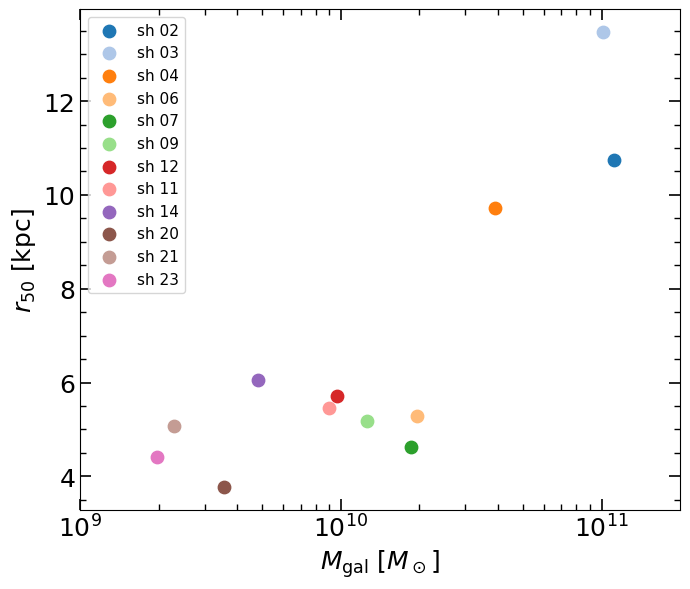

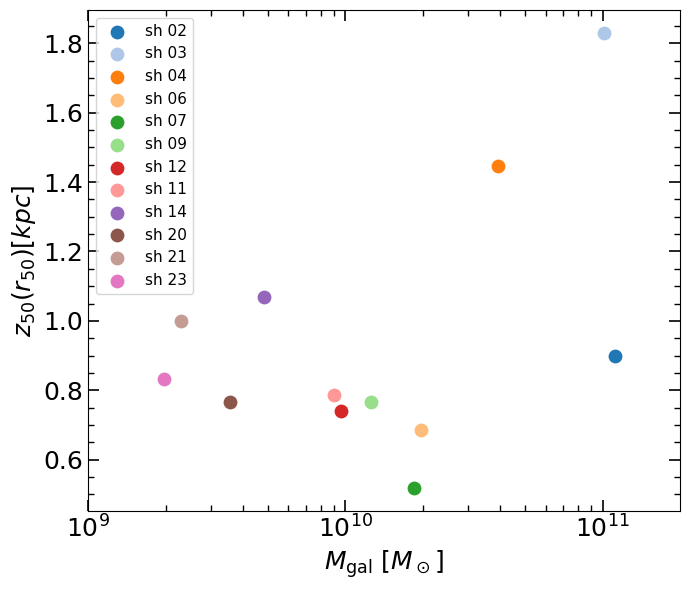

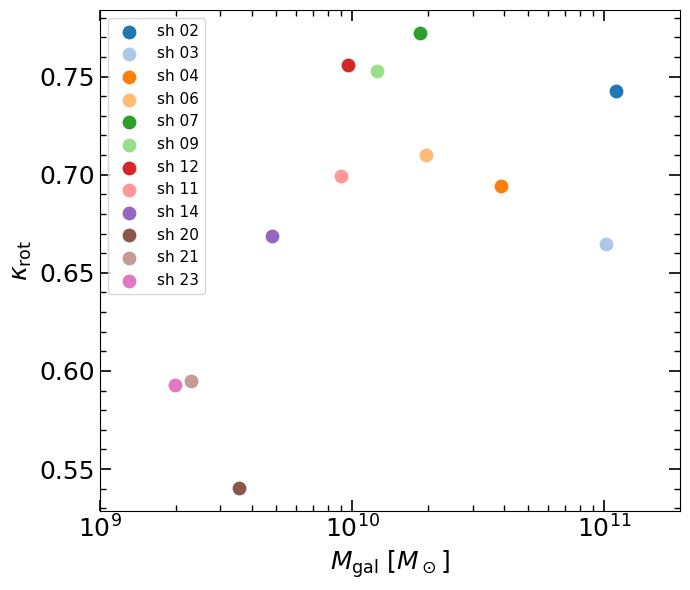

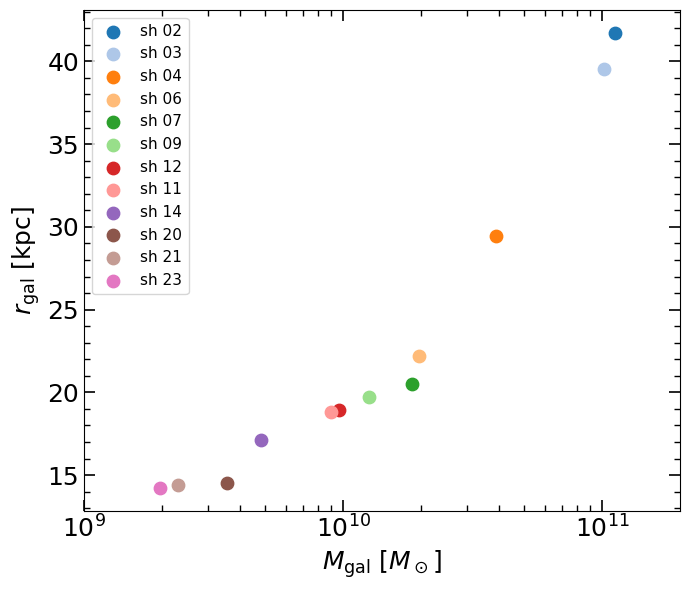

In [4]:
import numpy as np
import matplotlib.pyplot as plt


# Misma paleta de colores que los plots anteriores
colors = plt.cm.tab20(np.linspace(0, 1, 19))

data = np.loadtxt('../_data/z50_r50_krot_vs_Mgal.dat')
Id = data[:,0].astype(int)
Mgal = data[:,1]
rgal = data[:,2]
r50  = data[:,3]
z50  = data[:,4]
krot = data[:,5]


# === 1) r50 vs Mgal ===
fig, ax = plt.subplots(figsize=(7,6))
for i in range(len(Id)):
    ax.scatter(Mgal[i], r50[i], color=colors[i],label=f'sh {int(Id[i]):02d}', s=80)

ax.set_xlabel(r'$M_{\rm gal}$ [$M_\odot$]', fontsize=18)
ax.set_ylabel(r'$r_{50}$ [kpc]', fontsize=18)
ax.set_xscale('log')
ax.set_xlim(1e9,10**11.3)
ax.tick_params( labelsize=18)
ax.tick_params('both', length=8, width=1.2, which='major', direction='in', top=True, right=True)
ax.tick_params('both', length=4, width=1.0, which='minor', direction='in', top=True, right=True)
ax.minorticks_on()
ax.legend(frameon=True, fontsize=11)
fig.tight_layout()
fig.savefig('../_imagenes/r50_vs_Mgal.png', dpi=200)

# === 2) z50_at_r50 vs Mgal ===
fig, ax = plt.subplots(figsize=(7,6))
for i in range(len(Id)):
    ax.scatter(Mgal[i], z50[i], color=colors[i], label=f'sh {int(Id[i]):02d}', s=80)

ax.set_xlabel(r'$M_{\rm gal}$ [$M_\odot$]', fontsize=18)
ax.set_ylabel(r'$z_{50}(r_{50}) [kpc]$', fontsize=18)
ax.set_xscale('log')
ax.set_xlim(1e9,10**11.3)
ax.tick_params( labelsize=18)
ax.tick_params('both', length=8, width=1.2, which='major', direction='in', top=True, right=True)
ax.tick_params('both', length=4, width=1.0, which='minor', direction='in', top=True, right=True)
ax.minorticks_on()
ax.legend(frameon=True, fontsize=11)
fig.tight_layout()
fig.savefig('../_imagenes/z50_vs_Mgal.png', dpi=200)

# === 3) krot vs Mgal ===
fig, ax = plt.subplots(figsize=(7,6))
for i in range(len(Id)):
    ax.scatter(Mgal[i], krot[i], color=colors[i], label=f'sh {int(Id[i]):02d}', s=80)

ax.set_xlabel(r'$M_{\rm gal}$ [$M_\odot$]', fontsize=18)
ax.set_ylabel(r'$\kappa_{\rm rot}$', fontsize=18)
ax.set_xscale('log')
ax.set_xlim(1e9,10**11.3)
ax.tick_params( labelsize=18)
ax.tick_params('both', length=8, width=1.2, which='major', direction='in', top=True, right=True)
ax.tick_params('both', length=4, width=1.0, which='minor', direction='in', top=True, right=True)
ax.minorticks_on()
ax.legend(frameon=True, fontsize=11)
fig.tight_layout()
fig.savefig('../_imagenes/krot_vs_Mgal.png', dpi=200)

# === 4) rgal vs Mgal ===
fig, ax = plt.subplots(figsize=(7,6))
for i in range(len(Id)):
    ax.scatter(Mgal[i], rgal[i], color=colors[i], label=f'sh {int(Id[i]):02d}', s=80)

ax.set_xlabel(r'$M_{\rm gal}$ [$M_\odot$]', fontsize=18)
ax.set_ylabel(r'$r_{\rm gal}$ [kpc]', fontsize=18)
ax.set_xscale('log')
ax.set_xlim(1e9,10**11.3)
ax.tick_params( labelsize=18)
ax.tick_params('both', length=8, width=1.2, which='major', direction='in', top=True, right=True)
ax.tick_params('both', length=4, width=1.0, which='minor', direction='in', top=True, right=True)
ax.minorticks_on()
ax.legend(frameon=True, fontsize=11)
fig.tight_layout()
fig.savefig('../_imagenes/rgal_vs_Mgal.png', dpi=200)

plt.show()